In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import nltk
import re #regex
import networkx as nx
import matplotlib.pyplot as plt

Eventually create a list of major codes and run a for loop to get all dataframes

In [2]:
def extract_course_catalog_info(dept): #where dept is a string
    site_url = 'https://www.ucsd.edu/catalog/courses/' + dept + '.html'
    page = requests.get(site_url)
    soup = BeautifulSoup(page.content, 'html.parser')
    

In [3]:
#site_url = 'https://www.ucsd.edu/catalog/courses/' + 'dept' + '.html'

dept = 'MATH'
site_url = 'https://www.ucsd.edu/catalog/courses/MATH.html'
page = requests.get(site_url)
soup = BeautifulSoup(page.content, 'html.parser')

#https://stackoverflow.com/questions/49010813/how-to-find-a-particular-class-in-beautifulsoup-using-findall

# Looking at just names and descriptions w/ htmlclass separation

In [4]:
#full_list = soup.find_all("p", {"class": "anchor-parent"}) 

names = soup.find_all("p", {"class": "course-name"})
descriptions = soup.find_all("p", {"class": "course-descriptions"}) #includes prereqs (so want to extract that)

In [5]:
df = pd.DataFrame(columns=['Course Name', 'Course Description', 'Course Units'])
courses = {}
department = {"WARR","WCWP","VIS","UROL","USP","UNAF","TDAC","TDDE","TDDM","TDDR","TDGE",
              "TDGR","TDHD","TDHT","TDMV","TDPF","TDPR","TDPW","TDTR","TMC","TWS","SE","SIO",
              "SIOB","SIOC","SIOG","SOCE","SOCG","SOCI","SOMC","SOMI","SPPS","SURG","RAD","RELI",
              "REV","RMAS","RMED","PATH","PEDS","PHAR","PHIL","PHYS","POLI","PSY","PSYC","OPTH",
              "ORTH","NANO","NEWU","NEUG","MAE","MATH","MATS","MBC","MCWP","MED","MGT","MGTA","MGTF",
              "MGTP","MMW","MSED","MUIR","MUS","LTWR","LTWL","LTTH","LTSP","LTRU","LTLA","LTKO","LTIT",
              "LTGM","LTGK","LTFR","LTEU","LTEN","LTEA","LTCS","WES","AESE","AIP", "ANAR", "ANBI", "ANES", 
              "ANSC", "ANTH", "AUD", "AWP", "BENG", "BGGN","BGRD","BGSE", "BIBC", "BICD", "BIEB","BILD","BIMM", 
              "BIOM","BIPN","BISP","BNFO","CAT","CCS","CENG","CGS","CHEM","CHIN","CLIN","CLRE","CMM","COGR","COGS",
              "COMM","CSE","CSS", "DDPM","DERM","DOC","DSC","DSE","DSGN","ECE","ECON","EDS","EMED",
              "ENG","ENVR","ERC","ESYS","ETHN","ETIM","EXPR","FILM","FMPH","FPM","GLBH","GPCO","GPEC",
              "GPGN","GPIM","GPLA","GPPA","GPPS","HDS","HIAF","HIEA","HIEU","HIGR","HILA","HILD","HINE",
              "HISC","HITO","HIUS","HMNR","HUM","INTL","JAPN","JWSP","LATI","LHCO","LIAB","LIDS","LIFR",
              "LIGM","LIGN","LIHL","LIIT","LIPO","LISL","LISP","LTAM","LTCO"}

for course, description in zip(names, descriptions):
    course, description = course.getText(), description.getText()
    
    # Course ID check to filter upper div. classes.
    course_id = course[course.index(' ')+1:course.index('.')]
    while course_id[-1].isalpha() or course_id[-1] == '-':
        course_id = course_id[:-1]
    course_id = int(course_id)
    if course_id >= 200:
        continue
    
    # Grabs course info.
    course_name = course[:course.index('.')]
    prereqs = description.split("Prerequisites:",1)[1]
    
    for i, char in enumerate(prereqs):
        if char == "." or char ==";":
            prereqs = prereqs[:i]
            
    prereqs_and = prereqs.split(" and ")
    #print(prereqs_and)
    prereqs_list = []
    
    #[[class1,class2],[class3,class4]] reads as "class 1 or class 2 and class 3 or class 4"
    for i, word in enumerate(prereqs_and):
        #print(word)
        word = word.replace(',','')
        word = word.replace('higher','')
        word = word.replace('better','')
        word = word.replace(' with a grade of C–','')
        prereqs_list.append(word.split(" or "))
       # elif word in department:
        #    prereqs_list.append(word + prereqs[i+1])
   
    courses[course_name] = prereqs_list
    course_title = course[course.index('.')+1:course.index('(')-1]
    course_units = course[course.index('('):course.index(')')+1]
    
    # Append row to data frame.
    df = df.append({
        'Course Name': course_name,
        'Course Description': description,
        'Course Units': course_units
    }, ignore_index=True)



What class: MATH 18


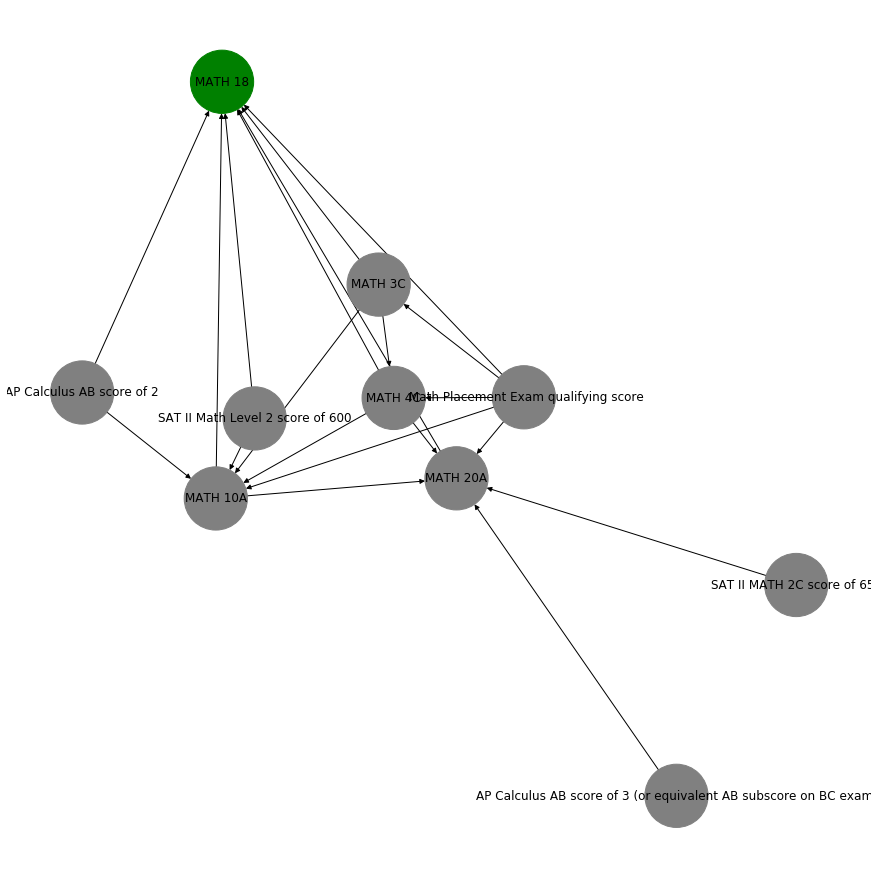

In [8]:
already_created = []
edges = []
def runner(parse_course, edge_list, created):
    created.append(parse_course)
    if parse_course in courses:
        for sequence in courses[parse_course]:
            for course in sequence:
                if course != '':
                    edge_list.append((course,parse_course))
                    if course not in created:
                        created.append(course)
                        runner(course, edge_list, created) 
                

    return edge_list

test1 = input("What class: ")
runner(test1, edges, already_created)
G = nx.DiGraph()
G.add_edges_from(edges)
colors = []
for node in G.nodes():
    if node == test1:
        colors.append("Green")
    else:
        colors.append("Grey")
plt.figure(3,figsize=(12,12))
nx.draw(G, with_labels=True, node_color = colors, node_size = 4000)

plt.show()



In [7]:
name_list = [] #this is in HTML contains all course header info

for x in names:
    name_list.append(str(x))

In [30]:
course_ids = []
course_names = []
course_units = [] 

for n in np.arange(len(name_list) - 1):
    #for i in np.arange(len(name_list[n]) - 1):
    x = name_list[n]
    course_ids.append(x[len('<p class="course-name">') + len(dept) + 1 : x.index('.')])
    course_names.append(x[x.index('.')+2:len(x)-8])
    course_units.append(x[len(x)-6])

## Some course names are weird (why?) e.g. 'Foundations\n\t\t  of Teaching and Learning Mathematics I'

## Course units cut off (why?)

In [32]:
course_nums = []

for i in course_ids:
    course_nums.append(re.findall(r'\d+|\D+', i)) #regex makes id's in format 'Num' + 'Letter'    

#regex for this \d+|\D+

# just nums: r'^\d+'

#### use list comprehension it is cleaner

finding indices of class category

In [33]:


for i in course_nums:
    if len(i[0]) == 2:
        try:
            lower_div_i = course_ids.index(i[0]+i[1]) #last index of lower divisions
        except IndexError:
            lower_div_i = course_ids.index(i[0])
    if int(i[0]) < 200:
        try:
            upper_div_i = course_ids.index(i[0]+i[1]) #" " of upper divisions
        except IndexError:
            upper_div_i = course_ids.index(i[0])
        
#[i for i,val in enumerate(l) if val==]

https://stackoverflow.com/questions/6294179/how-to-find-all-occurrences-of-an-element-in-a-list


### How to find last value before 200

In [34]:
#converting description blocks into lists

desc_list = []
for i in descriptions:
    desc_list.append(re.findall(r"\w+,*", str(i)))

In [35]:
# Removing graduate courses

course_ids = course_ids[0:upper_div_i + 1]
course_names = course_names[0:upper_div_i + 1]
course_units = course_units[0:upper_div_i + 1]
desc_list = desc_list[0:upper_div_i + 1]

In [37]:
#extracting prerequisites.  

prereq_list = []

for i in np.arange(len(desc_list)):
    x = desc_list[i]
    try: 
        prereq_list.append(x[x.index('Prerequisites')+2:len(x)-1])
    except ValueError:
        print('prereq extraction error at index', i) 
        prereq_list.append('None')
prereq_list

[['Math', 'Placement', 'Exam', 'qualifying', 'score'],
 ['Math', 'Placement', 'Exam', 'qualifying', 'score'],
 ['Math',
  'Placement',
  'Exam',
  'qualifying',
  'score',
  'or',
  'MATH',
  '3C',
  'with',
  'a',
  'grade',
  'of',
  'C',
  'or',
  'better'],
 ['Math',
  'Placement',
  'Exam',
  'qualifying',
  'score,',
  'or',
  'AP',
  'Calculus',
  'AB',
  'score',
  'of',
  '2,',
  'or',
  'SAT',
  'II',
  'Math',
  'Level',
  '2',
  'score',
  'of',
  '600',
  'or',
  'higher,',
  'or',
  'MATH',
  '3C,',
  'or',
  'MATH',
  '4C'],
 ['AP',
  'Calculus',
  'AB',
  'score',
  'of',
  '3,',
  '4,',
  'or',
  '5',
  'or',
  'equivalent',
  'AB',
  'subscore',
  'on',
  'BC',
  'exam',
  'or',
  'MATH',
  '10A,',
  'or',
  'MATH',
  '20A'],
 ['AP',
  'Calculus',
  'BC',
  'score',
  'of',
  '3,',
  '4,',
  'or',
  '5,',
  'or',
  'MATH',
  '10B,',
  'or',
  'MATH',
  '20B'],
 ['span',
  'AP',
  'Calculus',
  'BC',
  'score',
  'of',
  '3,',
  '4,',
  'or',
  '5,',
  'or',
  'MATH',


## Check where the ValueErrors occur!  In some cases it may be faulty html e.g Math 157 has weird indent and misses prereq section

Before cell below, need to clear the following words/strings: 
'either'

and turn this:

'Students',
  'who',
  'have',
  'not',
  'completed',
  'listed',
  'prerequisites',
  'may',
  'enroll',
  'with',
  'consent',
  'of',
  'instructor'
  
into just " or + consent of instructor"


### might have to parse for or and make the lists 3d

In [22]:
prereqs_2d = []
for n in np.arange(len(course_ids)):
    ps = prereq_list[n]
    ps_2d = [[]]
    inner_i = 0
    for i in np.arange(len(ps)):    
        if ps[i] != 'and':
            ps_2d[inner_i].append(ps[i])
        #if ps[i] == 'students' or 
        else:
            ps_2d.append([])
            inner_i = inner_i + 1
    prereqs_2d.append(ps_2d)

In [ ]:
n = [['MATH', '140A', 'or', 'consent', 'of', 'instructor'], [asdasdasd]]

prereqs_3d = []
for n in np.arange(len(course_ids)):
    ps = prereq_list[n]:
        for i in np.arange(len(ps)):
            for i2 in ps[i]:
                if i2 

In [23]:
course_ids.index('100A')

21

In [24]:
prereqs_2d[45]

[['MATH', '140A', 'or', 'consent', 'of', 'instructor']]

all classes are going to have to be in the same object unless more looping

In [23]:
for prereq in prereqs_for_some_class:
    preprereqs = [] # prereqs for this prereq 
    look at prereqs of the prereq:
        repeat?


for i in prereqs:
    prereqs_3d[course_ids.index(i)]
    

SyntaxError: invalid syntax (<ipython-input-23-889b7b9f37a0>, line 3)

# Want to create dataframe with Columns: name, ID, prereqs, descs (?)

In [ ]:
course_info_df = pd.DataFrame({'Course id': course_ids, 'Course name': course_names, 'Course units' = course_units, 'Prereqs' = })

Course names array must be in 2d.

[[Math 2, Introduction to College Mathematics], [MATH 3, Precalculus] ...] 

In [78]:

#course_page = course_page[0:int(np.where(course_page == '<p class="course-name">MATH 200A-B-C. Algebra (4-4-4)</p>')[0])]

(205,)


In [51]:
courses = []
start = ' <p class="course-name"> '
stop = '</p>'
for i in course_page:
    for s in i:
        

SyntaxError: unexpected EOF while parsing (<ipython-input-51-89e5bcb3f799>, line 5)

# GRAPHS

adjacency matrix or array of vertex pairs?

-adj lists

have to consider inter departmental case and how to access their respective course_ids etc

The loop should keep going as long as it can find the class in a prereq object.

dictionaries?  [Dept, ID] : [prereqs]

In [ ]:
def get_prereq(dept, num):
    a = course_ids.index(num) # [!] need to specify for dept
    return prereqs_3d[a]

#### The recursive part

input: course
intermediary input: the course's immediate prerequisites

the loop: should iterate down until no more prereq

output: A graph

In [ ]:
eg_prq = [ [['CSE', '8B'], ['CSE','11']],  [['MATH', '18'], ['MATH', '31AH']], [['MATH', '20E']], [['MATH','180A']] ]

map_graph = []
for i1 in eg_prq:
    for i2 in i1:
        prqs = get_prereq(i2[0], i2[1])
        
        
        
    map_graph.append([c1, c2])
        
        #dept = n[0][0]
                
                if eg_prq[i] == prereq_list[x] 

In [9]:
a = []
a.append(1)


In [10]:
a

[1]